Welcome

In this notebook I am going to build a forecasting model with time series data and display the results in a locally run dashboard.  The data will come from the United Nations, and I will be using an ARIMA model to make my forecasts. 

The following notebook will walk you through the steps I took to explore and visualize my data, test it for collinearity, stationarity, seasonality and trend. I also use the unsupervised learning technique of Dynamic Time Warping to try to understand how similar each series is to the others. Finally I perform a grid search to find the optimal parameters to model each series and then save those models for later use in my dashboard. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import warnings
from pandas.plotting import autocorrelation_plot

In [2]:
from Capstone.cleaning import cleaning
from Capstone.models import modeling

In [3]:
%pylab inline
import statsmodels

print('statsmodels: %s' % statsmodels.__version__)

Populating the interactive namespace from numpy and matplotlib
statsmodels: 0.9.0


In [4]:
# Module for Dynamic Time Warping
# dtw is available at https://github.com/pierre-rouanet/dtw
from dtw import dtw

# Get Data

Our data comes from The FAO of the United Nations, and is a surprisingly clean dataset with no missing values, going back all the way to 1990. http://www.fao.org/worldfoodsituation/foodpricesindex/en/

In [5]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/data/Food_price_indices_data_jul.csv"
food_data = pd.read_csv(datafile)
food_data.head()

,Date,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
0,1/1990,108.7,112.3,94.3,106.4,73.0,201.5
1,2/1990,109.9,117.7,91.9,104.0,72.5,207.9
2,3/1990,107.9,119.6,73.6,102.1,74.6,218.0
3,4/1990,114.2,131.0,85.2,105.1,71.8,216.3
4,5/1990,111.2,130.5,70.0,105.3,74.4,207.2


# Clean Data

Change the Date column to a datetime column and drop the general Food Price Index, which is a combination of the 5 other indices.

In [6]:
# change date to datetime and drop unneeded rows
clean_food_data = cleaning.clean_food_data(food_data)

In [7]:
clean_food_data.tail()

,Date,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
337,2018-02-01,170.3,191.1,161.3,158.0,192.4
338,2018-03-01,171.0,197.4,165.4,156.8,185.5
339,2018-04-01,170.4,204.1,168.5,154.6,176.1
340,2018-05-01,169.3,215.2,172.6,150.6,175.3
341,2018-06-01,169.8,213.2,166.2,146.1,177.4


# Explore and Visualize Data
The scale of the data is 2002-2004 = 100.0
 
First, look at the preliminary statistics of the data and see how they compare to each other. Then, make a line plot and a histogram of the data. After that, we make a correlation matrix to see how much each series is correlated to the others. Next up is a scatter plot followed by taking the differenced data through an ADFuller test to check for stationarity. 

In [8]:
indexed_df = clean_food_data.set_index(['Date'])
indexed_df.to_csv('data/indexed_clean_df.csv')

In [9]:
indexed_df.describe()

,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
count,342.000000,342.000000,342.000000,342.000000,342.000000
mean,135.943860,140.497661,137.465789,134.756140,182.055848
std,30.528729,57.171255,50.422226,53.183568,74.248813
min,84.500000,66.100000,80.200000,57.100000,72.900000
25%,113.950000,93.425000,97.850000,90.950000,127.850000
50%,128.850000,117.200000,113.400000,122.950000,166.850000
75%,162.075000,189.100000,165.850000,166.550000,218.950000
max,212.000000,275.400000,267.700000,286.500000,420.200000


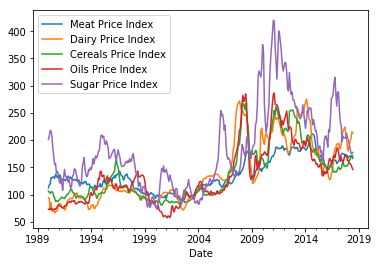

In [10]:
indexed_df.plot()
plt.show()

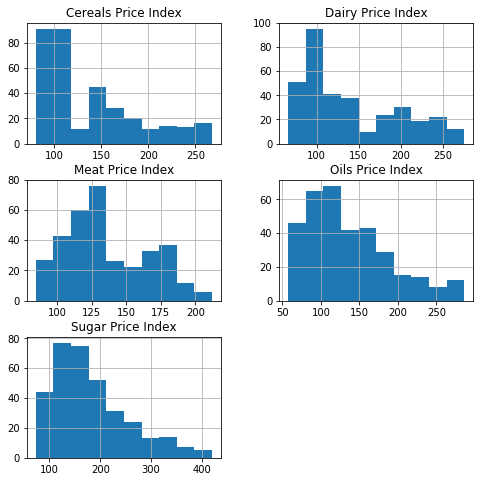

In [11]:
indexed_df.hist(figsize=(8,8))
plt.show()

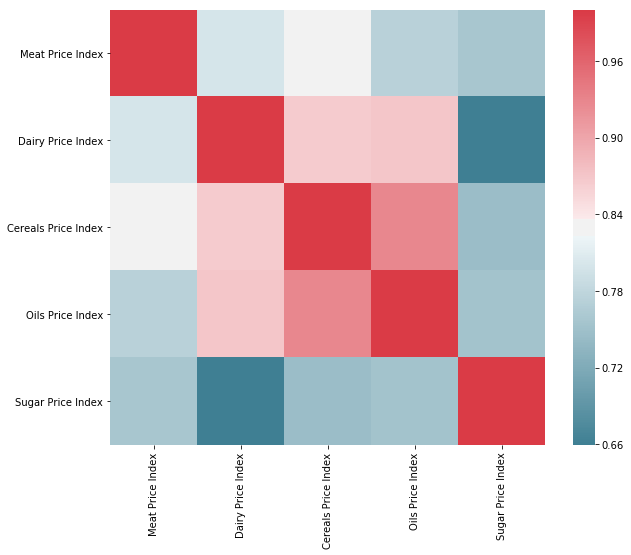

In [12]:
# Correlation matrix

f, ax = plt.subplots(figsize=(10, 8))
corr = indexed_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [13]:
# checking for collinearity
food_corr = np.corrcoef(indexed_df, rowvar=False)
eig_val, eig_vec = np.linalg.eig(food_corr)
eig_val

array([4.2023613 , 0.37508278, 0.23146938, 0.05841415, 0.13267239])

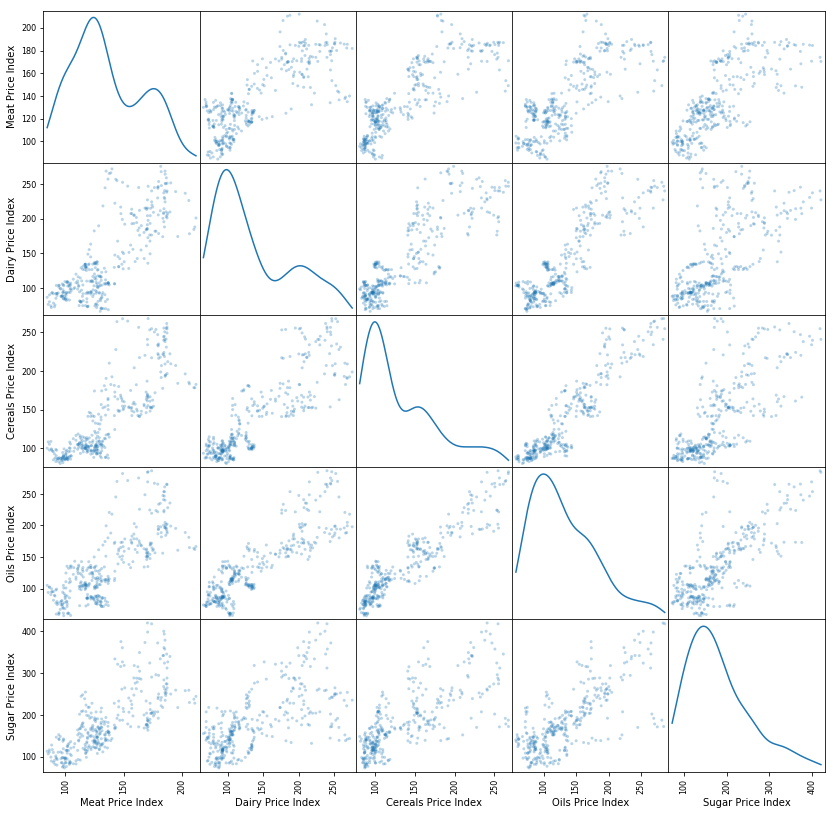

In [14]:
pd.plotting.scatter_matrix(indexed_df, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [15]:
df_diff = indexed_df.diff()

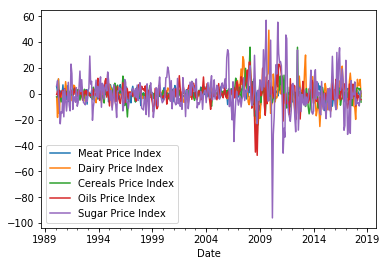

In [16]:
df_diff.plot() # looking for stationarity
plt.show()

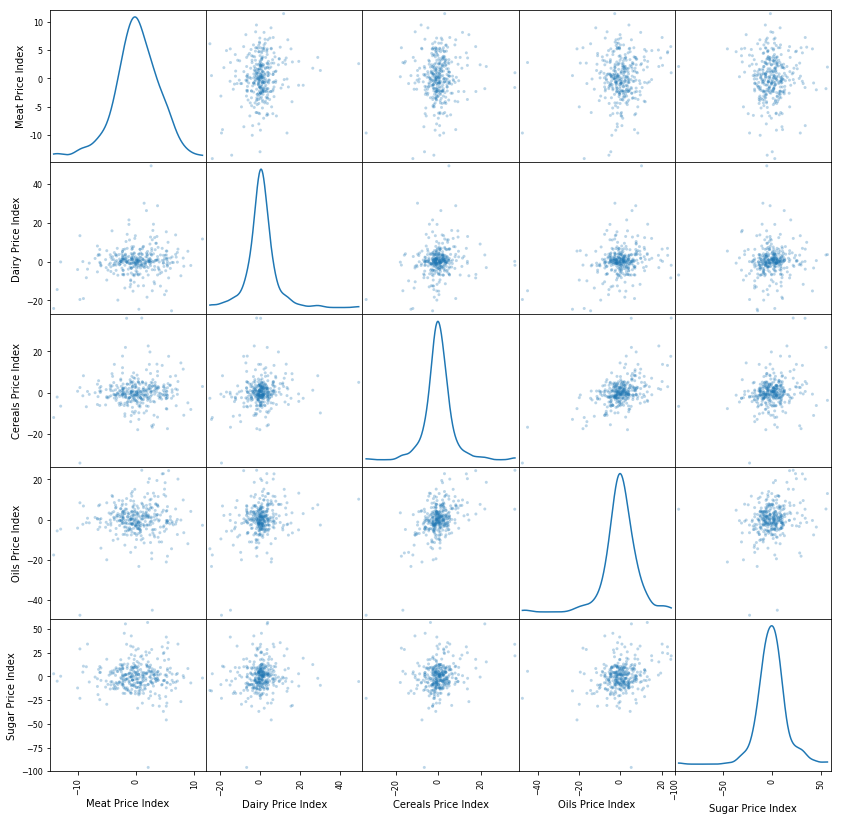

In [17]:
pd.plotting.scatter_matrix(df_diff, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [18]:
# using the ADFuller test from statsmodel to check for stationarity

def test_fuller(df):
    result = adfuller(df[1:])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [19]:
test_fuller(df_diff['Meat Price Index'])

ADF Statistic: -5.277695
p-value: 0.000006
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572


In [20]:
test_fuller(df_diff['Cereals Price Index'])

ADF Statistic: -4.911983
p-value: 0.000033
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572


In [21]:
test_fuller(df_diff['Dairy Price Index'])

ADF Statistic: -6.427264
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [22]:
test_fuller(df_diff['Oils Price Index'])

ADF Statistic: -5.623695
p-value: 0.000001
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572


In [23]:
test_fuller(df_diff['Sugar Price Index'])

ADF Statistic: -12.189071
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


# Unsupervised Learning

Using Dynamic Time Warping we can look to see how similar each series is to each other using our choice of distance metrics.

In [24]:
# accelerated_dtw uses the cdist function from scipy, lots of distance metric options

dist, cost, acc, path = dtw.accelerated_dtw(indexed_df['Meat Price Index'].values,
                indexed_df['Dairy Price Index'].values, dist='euclidean' )

Text(0,0.5,'Dairy')

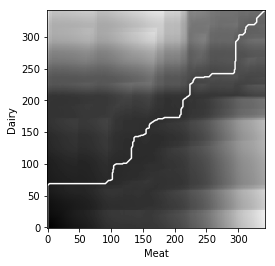

In [25]:
# testing out dtw for bugs
imshow(acc.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot(path[0], path[1], 'w')
xlim((-0.5, acc.shape[0]-0.5))
ylim((-0.5, acc.shape[1]-0.5))
xlabel('Meat')
ylabel('Dairy')

In [26]:
# if you have to do a thing more than 3 times make a function
# also add labels to everything

def plot_dtw(x, y, dist, cmap):
    dist, cost, acc, path = dtw.accelerated_dtw(x, y , dist=dist)
    imshow(acc.T, origin='lower', cmap=cmap, interpolation='nearest')
    plot(path[0], path[1], 'w')
    xlim((-0.5, acc.shape[0]-0.5))
    ylim((-0.5, acc.shape[1]-0.5))
    plt.title(dist)

<Figure size 432x288 with 0 Axes>

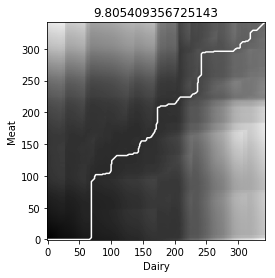

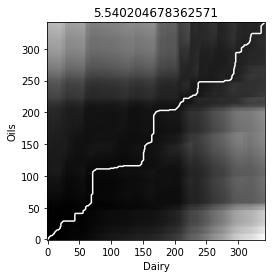

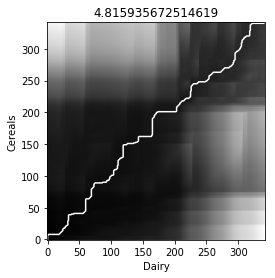

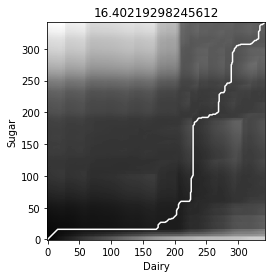

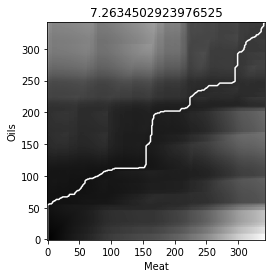

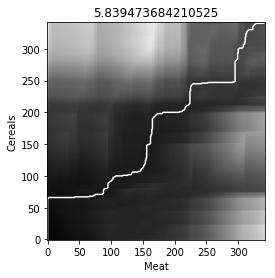

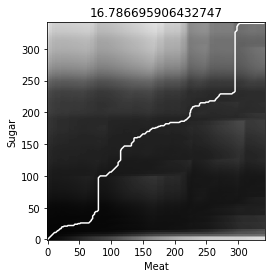

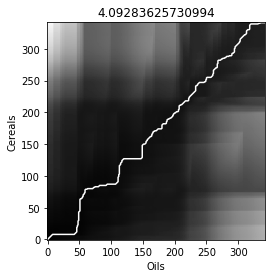

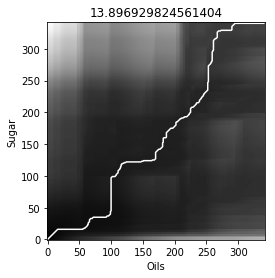

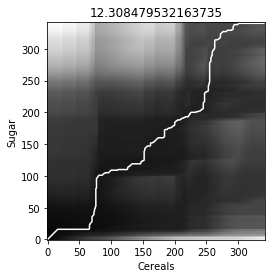

In [27]:
# comparing each index to the others
indices = {'Dairy': indexed_df['Dairy Price Index'].values,
           'Meat': indexed_df['Meat Price Index'].values,
           'Oils': indexed_df['Oils Price Index'].values,
           'Cereals': indexed_df['Cereals Price Index'].values,
           'Sugar': indexed_df['Sugar Price Index'].values}
plt.figure()
for i, index_i in enumerate(indices):
    for j, index_j in enumerate(indices):
        if i < j:
            plt.figure()
            plot_dtw(indices[index_i], indices[index_j], 'euclidean', cm.gray)
            xlabel(index_i)
            ylabel(index_j)
plt.show()

# Supervised Learning
I chose to use an ARIMA model for the forecasting in this project because of the data I am using. The data from the FAO is a collection of 5 different commodity price indices, which track the monthly change in international prices for those food groups. This real world data has real world randomness in it's movement that I believe ARIMA can capture.

Using a grid search, I evaluated multiple parameters to find the optimal ones for each series. Once the best parameters are identified the values and score are printed and we save a model for each series using those parameters. We are using Mean Squared Error(MSE) as our evaluation metric. MSE measures the average squared difference between the predicted value and the actual value. I chose to use MSE instead of Mean Absolute Error because there are no outliers in this data; we care about each value. 

In [28]:
# different parameter values to test
p_values = [0, 1, 4, 6, 8, 10, 12]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

In [31]:
modeling.evaluate_models(indexed_df['Meat Price Index'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=2164.167
ARIMA(0, 0, 1) MSE=619.085
ARIMA(0, 1, 0) MSE=19.771
ARIMA(0, 1, 1) MSE=17.933
ARIMA(0, 1, 2) MSE=16.319
ARIMA(0, 2, 0) MSE=18.010
ARIMA(0, 2, 1) MSE=21.501
ARIMA(1, 0, 0) MSE=19.715
ARIMA(1, 1, 0) MSE=17.204
ARIMA(1, 2, 0) MSE=17.513
ARIMA(1, 2, 1) MSE=18.573
ARIMA(1, 2, 2) MSE=18.845
ARIMA(4, 0, 0) MSE=16.679
ARIMA(4, 1, 0) MSE=16.054
ARIMA(4, 1, 1) MSE=16.366
ARIMA(4, 2, 0) MSE=21.529
ARIMA(4, 2, 1) MSE=16.516
ARIMA(6, 1, 0) MSE=15.952
ARIMA(6, 1, 1) MSE=15.922
ARIMA(6, 2, 0) MSE=21.485
ARIMA(6, 2, 1) MSE=16.397
ARIMA(8, 1, 0) MSE=15.737
ARIMA(8, 1, 1) MSE=15.882
ARIMA(8, 2, 0) MSE=19.093
ARIMA(8, 2, 1) MSE=16.699
ARIMA(10, 0, 0) MSE=15.779
ARIMA(10, 1, 0) MSE=15.717
ARIMA(10, 1, 1) MSE=16.129
ARIMA(10, 2, 0) MSE=17.801
ARIMA(12, 0, 0) MSE=15.872
ARIMA(12, 1, 0) MSE=16.347
ARIMA(12, 1, 1) MSE=16.039
Best ARIMA(10, 1, 0) MSE=15.717


In [32]:
modeling.evaluate_models(indexed_df['Sugar Price Index'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=13351.405
ARIMA(0, 0, 1) MSE=3825.773
ARIMA(0, 1, 0) MSE=442.289
ARIMA(0, 1, 1) MSE=383.679
ARIMA(0, 1, 2) MSE=387.320
ARIMA(0, 2, 0) MSE=578.035
ARIMA(0, 2, 1) MSE=479.820
ARIMA(0, 2, 2) MSE=389.157
ARIMA(1, 0, 0) MSE=445.895
ARIMA(1, 0, 2) MSE=391.136
ARIMA(1, 1, 0) MSE=393.240
ARIMA(1, 1, 1) MSE=387.880
ARIMA(1, 2, 0) MSE=570.825
ARIMA(1, 2, 2) MSE=392.965
ARIMA(4, 0, 0) MSE=402.168
ARIMA(4, 1, 0) MSE=397.253
ARIMA(4, 2, 0) MSE=477.886
ARIMA(6, 0, 0) MSE=410.138
ARIMA(6, 0, 1) MSE=410.708
ARIMA(6, 1, 0) MSE=407.524
ARIMA(6, 2, 0) MSE=494.536
ARIMA(8, 0, 0) MSE=425.284
ARIMA(8, 1, 0) MSE=420.714
ARIMA(8, 2, 0) MSE=495.485
ARIMA(10, 1, 0) MSE=427.126
ARIMA(10, 2, 0) MSE=481.801
ARIMA(10, 2, 1) MSE=431.659
ARIMA(12, 0, 0) MSE=436.232
ARIMA(12, 1, 0) MSE=425.639
ARIMA(12, 2, 0) MSE=459.959
Best ARIMA(0, 1, 1) MSE=383.679


In [33]:
modeling.evaluate_models(indexed_df['Oils Price Index'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=5070.353
ARIMA(0, 0, 1) MSE=1435.087
ARIMA(0, 1, 0) MSE=96.254
ARIMA(0, 1, 1) MSE=86.371
ARIMA(0, 1, 2) MSE=85.462
ARIMA(0, 2, 0) MSE=117.579
ARIMA(0, 2, 1) MSE=99.086
ARIMA(0, 2, 2) MSE=96.773
ARIMA(1, 0, 0) MSE=95.426
ARIMA(1, 0, 1) MSE=85.991
ARIMA(1, 0, 2) MSE=85.106
ARIMA(1, 1, 0) MSE=81.964
ARIMA(1, 1, 1) MSE=86.965
ARIMA(1, 2, 0) MSE=107.255
ARIMA(1, 2, 2) MSE=95.309
ARIMA(4, 0, 0) MSE=93.793
ARIMA(4, 1, 0) MSE=94.875
ARIMA(4, 1, 1) MSE=95.340
ARIMA(4, 1, 2) MSE=98.165
ARIMA(4, 2, 0) MSE=113.175
ARIMA(4, 2, 1) MSE=113.484
ARIMA(6, 1, 0) MSE=95.057
ARIMA(6, 1, 1) MSE=91.468
ARIMA(6, 2, 0) MSE=117.917
ARIMA(6, 2, 1) MSE=106.538
ARIMA(6, 2, 2) MSE=102.387
ARIMA(8, 1, 0) MSE=98.529
ARIMA(8, 2, 0) MSE=119.353
ARIMA(8, 2, 1) MSE=107.573
ARIMA(8, 2, 2) MSE=117.907
ARIMA(10, 2, 0) MSE=110.326
Best ARIMA(1, 1, 0) MSE=81.964


In [34]:
modeling.evaluate_models(indexed_df['Cereals Price Index'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=5072.801
ARIMA(0, 0, 1) MSE=1433.610
ARIMA(0, 1, 0) MSE=67.443
ARIMA(0, 1, 1) MSE=61.953
ARIMA(0, 1, 2) MSE=59.856
ARIMA(0, 2, 0) MSE=87.678
ARIMA(0, 2, 1) MSE=68.793
ARIMA(0, 2, 2) MSE=73.606
ARIMA(1, 0, 0) MSE=66.647
ARIMA(1, 0, 2) MSE=59.553
ARIMA(1, 1, 0) MSE=60.060
ARIMA(1, 1, 1) MSE=60.012
ARIMA(1, 1, 2) MSE=60.287
ARIMA(1, 2, 0) MSE=75.742
ARIMA(1, 2, 1) MSE=61.989
ARIMA(1, 2, 2) MSE=62.125
ARIMA(4, 0, 0) MSE=61.408
ARIMA(4, 0, 1) MSE=64.270
ARIMA(4, 1, 0) MSE=61.453
ARIMA(4, 1, 1) MSE=62.688
ARIMA(4, 2, 0) MSE=72.554
ARIMA(4, 2, 1) MSE=63.173
ARIMA(4, 2, 2) MSE=65.324
ARIMA(6, 0, 0) MSE=64.117
ARIMA(6, 0, 1) MSE=64.578
ARIMA(6, 1, 0) MSE=63.510
ARIMA(6, 1, 1) MSE=64.959
ARIMA(6, 2, 0) MSE=73.022
ARIMA(6, 2, 2) MSE=66.779
ARIMA(8, 0, 0) MSE=65.434
ARIMA(8, 0, 1) MSE=65.302
ARIMA(8, 1, 0) MSE=65.683
ARIMA(8, 1, 1) MSE=66.309
ARIMA(8, 2, 0) MSE=76.038
ARIMA(8, 2, 2) MSE=67.955
ARIMA(10, 0, 0) MSE=67.264
ARIMA(10, 0, 1) MSE=67.312
ARIMA(10, 1, 0) MSE=67.821
ARIMA

In [35]:
modeling.evaluate_models(indexed_df['Dairy Price Index'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=5998.958
ARIMA(0, 0, 1) MSE=1593.119
ARIMA(0, 1, 0) MSE=111.099
ARIMA(0, 1, 1) MSE=81.258
ARIMA(0, 1, 2) MSE=83.924
ARIMA(0, 2, 0) MSE=104.083
ARIMA(0, 2, 1) MSE=103.773
ARIMA(0, 2, 2) MSE=99.044
ARIMA(1, 0, 0) MSE=110.859
ARIMA(1, 0, 1) MSE=80.841
ARIMA(1, 0, 2) MSE=83.669
ARIMA(1, 1, 0) MSE=81.284
ARIMA(1, 1, 1) MSE=84.335
ARIMA(1, 1, 2) MSE=89.716
ARIMA(1, 2, 0) MSE=112.569
ARIMA(4, 1, 0) MSE=90.384
ARIMA(4, 2, 0) MSE=104.493
ARIMA(4, 2, 1) MSE=98.007
ARIMA(6, 1, 0) MSE=92.379
ARIMA(6, 1, 1) MSE=90.937
ARIMA(6, 2, 0) MSE=104.344
ARIMA(6, 2, 1) MSE=99.228
ARIMA(8, 1, 0) MSE=94.102
ARIMA(8, 2, 0) MSE=104.945
ARIMA(8, 2, 1) MSE=106.861
ARIMA(10, 1, 0) MSE=97.620
ARIMA(10, 2, 0) MSE=107.733
ARIMA(10, 2, 1) MSE=107.009
ARIMA(10, 2, 2) MSE=109.358
ARIMA(12, 1, 0) MSE=101.222
ARIMA(12, 2, 0) MSE=109.344
ARIMA(12, 2, 1) MSE=100.619
Best ARIMA(1, 0, 1) MSE=80.841


# Save the Models
These models will be used in our dashboard program to create the actual forecast. 

In [37]:
sugar_model = ARIMA(indexed_df['Sugar Price Index'].values, order=(0,1,1))
sugar_model_fit = sugar_model.fit()
sugar_model_fit.save('SugarARIMA.pkl')

In [38]:
meat_model = ARIMA(indexed_df['Meat Price Index'].values, order=(10,1,0))
meat_model_fit = meat_model.fit()
meat_model_fit.save('MeatARIMA.pkl')

In [39]:
oils_model = ARIMA(indexed_df['Oils Price Index'].values, order=(1,1,0))
oils_model_fit = oils_model.fit()
oils_model_fit.save('OilsARIMA.pkl')

In [40]:
cereal_model = ARIMA(indexed_df['Cereals Price Index'].values, order=(1,0,2))
cereal_model_fit = cereal_model.fit()
cereal_model_fit.save('CerealsARIMA.pkl')

In [41]:
dairy_model = ARIMA(indexed_df['Dairy Price Index'].values, order=(1,0,1))
dairy_model_fit = dairy_model.fit()
dairy_model_fit.save('DairyARIMA.pkl')

# Write Up

The product I have developed for this final capstone is a forecasting engine displayed in a dashboard to predict if the global prices of food are going to go up or down. 

I specifically chose this kind of product because it addresses a problem I personally faced while performing my duties as a Sous Chef for The Court at Round Rock. During my tenure at The Court, I would periodically have to change the menu I had previously planned because the cost of ingredients would change. Price changes are not a new thing, but they do occasionally change enough that they have an impact and the people who feel those impacts are the ones who have a restricted budget, like I had. 

At its heart my product uses an ARIMA model. This model type is best for time series analysis because it takes the current data into account along with the errors from previous predictions. This essentially allows my model to 'see' where it 'is', where it's 'been', and where it 'went wrong' before making a new prediction.

I chose to make my product an interactive dashboard, so the chef could choose which commodities to view. I also kept its design simple so it would be easy to read and interpret. Most chefs are not going to be statisticians, but they can all understand a line graph. I also chose to only predict out three months so the graph would be easy to read. 

While building this project, I split the work up into callable modules. This small grouping of code makes it easier to locate the code you might later want to update, without having to dive into the whole notebook. The compartmentalizing also helps to make it easier to work in a production environment. 

Maintenance going forward could be as simple as updating the data pulled from the UN website and rerunning the models with the updated data. 